/opt/anaconda3/envs/kr8cht_embedding_comparison/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/kr8cht_embedding_comparison/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
[INFO] Project root set to: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous
Loaded 24 embeddings   ×   6 models   ×   14 targets
Using device: mps  |  DEBUG_MODE=False

══════════════════════════════════════════════════
A  PARTIALLY FINETUNED MODELS  –  MODEL COMPARISON
══════════════════════════════════════════════════


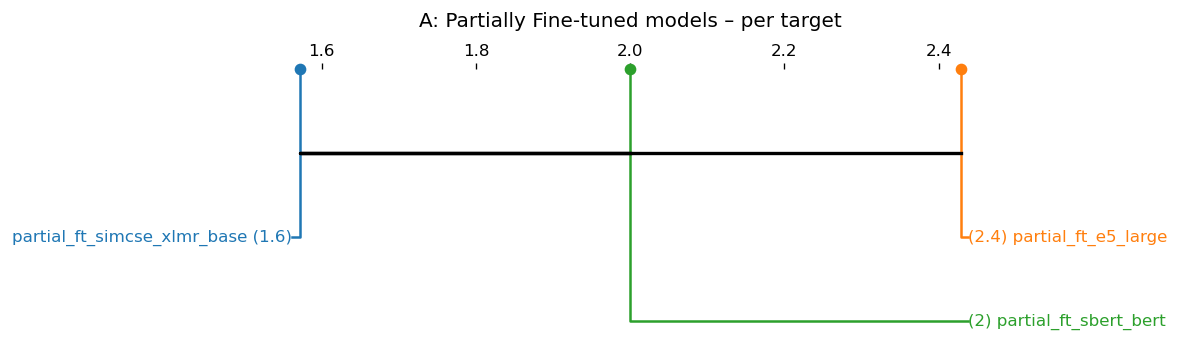

Plot saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/d_fine_tuned/plots/partial_ft_A_model_comparison_finetuned_cd.png

Median RRMSE per target (sorted low→high):
partial_ft_simcse_xlmr_base    0.983
partial_ft_sbert_bert          0.989
partial_ft_e5_large            0.998
  ↳ saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/d_fine_tuned/results/partial_ft_A_model_comparison_per_target_finetuned_median.csv

*Aligned-Friedman* (blocks = targets)
  χ²_F = 5.143    F_F = 2.925

*Original-Friedman* (blocks = targets)
  χ²_F = 5.143    p = 0.0764    F_F = 2.925

Nemenyi p-values (aligned post-hoc):
                             partial_ft_sbert_bert  partial_ft_simcse_xlmr_base  partial_ft_e5_large
partial_ft_sbert_bert                       1.0000                       0.4931               0.4931
partial_ft_simcse_xlmr_base                 0.4931                       1.0000               0.0604
partial_ft_e5_large                        

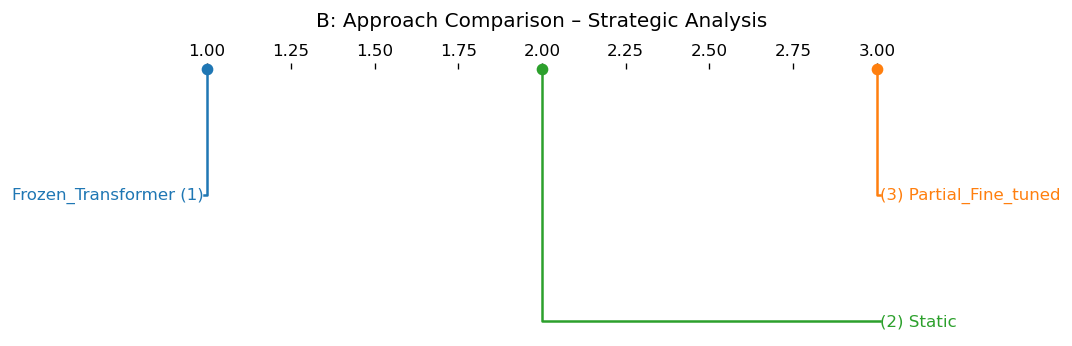

Plot saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/d_fine_tuned/plots/partial_ft_B_approach_comparison_cd.png

Median RRMSE per target (sorted low→high):
Frozen_Transformer    0.812
Static                0.902
Partial_Fine_tuned    0.989
  ↳ saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/d_fine_tuned/results/partial_ft_B_approach_comparison_median.csv

*Aligned-Friedman* (blocks = targets)
  χ²_F = 28.000    F_F = inf

*Original-Friedman* (blocks = targets)
  χ²_F = 28.000    p = 8.32e-07    F_F = inf

Nemenyi p-values (aligned post-hoc):
                    Static  Frozen_Transformer  Partial_Fine_tuned
Static              1.0000              0.0222              0.0222
Frozen_Transformer  0.0222              1.0000              0.0000
Partial_Fine_tuned  0.0222              0.0000              1.0000
  ↳ saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/d_fine_tuned/results/partial_ft_B_approach_comparis

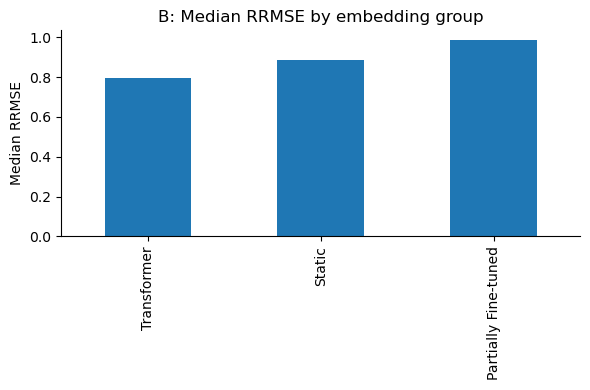

• Static vs Transformer: p = 0.00545 → SIGNIFICANT
• Static vs Partially Fine-tuned: p = 0.0511 → not significant
• Transformer vs Partially Fine-tuned: p = 0.0391 → SIGNIFICANT
Finished in   0.7 s


In [1]:
"""
d_fine_tuned.ipynb
───────────────────────────────────────────────────────────────────────────────
LoRA-based partial fine-tuning of three best frozen transformer encoders
of script b_frozen.

This script can run in two modes (controlled by REVIEW_MODE):

• COMPUTE mode (REVIEW_MODE = False) — full, end-to-end:
  1) Loads data and selects three encoders:
     - Checkpoints:
       * jegormeister/bert-base-dutch-cased-snli
       * sentence-transformers/paraphrase-xlm-r-multilingual-v1
       * embaas/sentence-transformers-multilingual-e5-large
  2) Partially fine-tunes each encoder with LoRA (80% layers frozen + adapter):
     - 90/10 split for learning-rate search over [5e-6, 2e-5, 5e-5, 1e-4]
     - Early stopping (patience=2), 3 epochs, batch=16, mixed precision on CUDA
  3) LOOCV evaluation:
     - Fine-tune per fold, predict, compute per-target RRMSE vs train-mean baseline
     - Saves per-encoder fold arrays: `partial_ft_{model}_loocv_rrmse.npy`
  4) Analysis & reporting:
     - A) Fine-tuned model comparison (per-target): CD-diagram + stats
     - B) Approach comparison (Static vs Frozen vs Partial Fine-tuned): CD + stats
     - C) Group comparisons (Mann–Whitney U), bar chart
     - Writes CSVs to `outputs/d_fine_tuned/results/` and plots to `outputs/d_fine_tuned/plots/`

• REVIEW mode (REVIEW_MODE = True):
  - Skips any data loading and fine-tuning.
  - Starts from saved artifacts in `outputs/d_fine_tuned/results/partial_ft_*_loocv_rrmse.npy`.
  - Recomputes and overwrites all downstream CSVs and figures so outputs match COMPUTE mode.

Inputs (artifacts expected to already exist for REVIEW mode):
- `outputs/a_static/results/baseline_{word2vec|fasttext}_loocv_rrmse.npy`
- `outputs/b_frozen/results/{embedding}_loocv_rrmse.npy`
- `outputs/d_fine_tuned/results/partial_ft_{sbert_bert|simcse_xlmr_base|e5_large}_loocv_rrmse.npy`  (REVIEW)

Outputs:
- `outputs/d_fine_tuned/results/partial_ft_{model}_loocv_rrmse.npy`                # COMPUTE
- `outputs/d_fine_tuned/results/partial_ft_A_model_comparison_*.csv`               # both modes
- `outputs/d_fine_tuned/results/B_approach_comparison_*.(csv)`                     # both modes
- `outputs/d_fine_tuned/plots/partial_ft_A_model_comparison_*.png`                 # both modes
- `outputs/d_fine_tuned/plots/partial_ft_A_model_comparison_finetuned_cd.png`      # both modes
- `outputs/d_fine_tuned/plots/partial_ft_B_approach_comparison_cd.png`                        # both modes
- `outputs/d_fine_tuned/plots/partial_ft_C_group_comparison.png`                   # both modes
"""

# ────────────────────────────────────────────
# Imports
# ────────────────────────────────────────────

import os
import sys
import time
import random
import warnings
import multiprocessing

from pathlib import Path

def get_project_root(marker: str = "LICENSE") -> Path:
    cwd = Path.cwd().resolve()
    for cand in (cwd, *cwd.parents):
        if (cand / marker).is_file():
            return cand
    raise FileNotFoundError(f"Could not find '{marker}' in {cwd} or parents.")

ROOT = get_project_root()
os.chdir(ROOT)
sys.path.insert(0, str(ROOT / "scripts"))

import contextlib
import glob
import io
import multiprocessing
import os
from pathlib import Path
import random
import shutil
import sys
import time
import traceback
import warnings
from itertools import combinations

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikit_posthocs as sp
import torch
import torch.nn as nn
from datasets import Dataset
from scipy.stats import friedmanchisquare, mannwhitneyu, rankdata, wilcoxon
from sklearn.model_selection import train_test_split
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm
from transformers import (
    AutoModel,
    AutoTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, TaskType, get_peft_model

# Local application
import a_static as BASE
import b_frozen as TRANS
import c_interim_report as INTERIM

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="huggingface/tokenizers")

# ────────────────────────────────────────────
# Paths
# ────────────────────────────────────────────

OUTPUT_DIR   = ROOT / "outputs"
FTUNED_DIR   = OUTPUT_DIR / "d_fine_tuned"
RESULTS_DIR  = FTUNED_DIR / "results"
TABLES_DIR   = RESULTS_DIR
PLOTS_DIR    = FTUNED_DIR / "plots"
TEMP_DIR     = FTUNED_DIR / "temp"

for p in (RESULTS_DIR, FTUNED_DIR, OUTPUT_DIR, PLOTS_DIR, TEMP_DIR):
    p.mkdir(parents=True, exist_ok=True)

# ────────────────────────────────────────────
# Global configuration
# ────────────────────────────────────────────

REVIEW_MODE = True 
DEBUG_MODE = False

N_CORES = min(6, multiprocessing.cpu_count())
os.environ.update({
    "OMP_NUM_THREADS": str(N_CORES),
    "MKL_NUM_THREADS": str(N_CORES),
    "NUMEXPR_NUM_THREADS": str(N_CORES),
    "TOKENIZERS_PARALLELISM": "true",
})

LORA_R, LORA_ALPHA, LORA_DROPOUT = 4, 16, 0.1
EPOCHS, BATCH = 3, 16

try:
    _emb0 = next(iter(INTERIM.data.keys()))
    _m0 = next(iter(INTERIM.data[_emb0].keys()))
    N_TARGETS = INTERIM.data[_emb0][_m0].shape[1]
except Exception:
    N_TARGETS = 14

# ──────────────────────────────────────────────────────────────
# 0.  Embedding selection
# ──────────────────────────────────────────────────────────────

# Two static baselines from a_static
BASELINE_EMB = INTERIM.BASELINE_EMB                

# Three selected sentence-transformers from b_frozen we fine-tune 
SELECTED_EMBS = ["sbert_bert", "simcse_xlmr_base", "e5_large"]

# checkpoints for the three fine-tuned models
CHECKPOINTS = {
    "sbert_bert":       "jegormeister/bert-base-dutch-cased-snli",
    "simcse_xlmr_base": "sentence-transformers/paraphrase-xlm-r-multilingual-v1",
    "e5_large":         "embaas/sentence-transformers-multilingual-e5-large",
}

# all 21 transformer embeddings defined in b_frozen
ALL_TRANSFORMER_RAW = sorted(
    set(TRANS.TRANSFORMER_POOL_EMBS.keys()) |
    set(TRANS.SENTENCE_TRANSFORMERS.keys())
)

# prefixed logical names
STATIC_EMBS        = [f"static_{e}"      for e in BASELINE_EMB]
TRANSFORMER_EMBS   = [f"transformer_{e}" for e in ALL_TRANSFORMER_RAW]
FINETUNED_EMBS     = [f"partial_ft_{e}"   for e in SELECTED_EMBS]

# ──────────────────────────────────────────────────────────────
# 1.  Model selection
# ──────────────────────────────────────────────────────────────
BASE_REGRESSORS = [
    "local_mean",
    "local_lasso",
    "local_rf",
    "chain_ERCcv_rf",
    "chain_ERCcv_lr",
    "global_rf",
]
STATIC_MODEL_NAMES      = [f"static_{m}"      for m in BASE_REGRESSORS]
TRANSFORMER_MODEL_NAMES = [f"transformer_{m}" for m in BASE_REGRESSORS]
models                  = STATIC_MODEL_NAMES + TRANSFORMER_MODEL_NAMES
models.append("partial_ft_regressor")


torch.set_num_threads(N_CORES)
RANDOM_SEED = BASE.RANDOM_SEED
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if getattr(torch.backends, "mps", None)
                 and torch.backends.mps.is_available()
    else "cpu"
)
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)
if device.type == "cuda": torch.cuda.manual_seed_all(RANDOM_SEED)
print(f"Using device: {device}  |  DEBUG_MODE={DEBUG_MODE}")


# ──────────────────────────────────────────────────────────────
# 2. Artifact loading (REVIEW-MODE)
# ──────────────────────────────────────────────────────────────
def load_finetuned_artifacts() -> dict:
    """
    Loads previously-saved artifacts from outputs/d_fine_tuned/results and returns:
      { 'partial_ft_<tag>': {'partial_ft_regressor': (folds x targets) ndarray } }
    """
    out = {}
    for raw_tag in SELECTED_EMBS:
        emb = f"partial_ft_{raw_tag}"
        fn  = RESULTS_DIR / f"{emb}_loocv_rrmse.npy"
        if not fn.exists():
            raise FileNotFoundError(
                f"Missing artifact: {fn}\nRun in COMPUTE mode once to generate, "
                "or place the saved npy files under outputs/d_fine_tuned/results/."
            )
        saved = np.load(fn, allow_pickle=True).item()
        arr = saved.get("partial_ft_regressor", next(iter(saved.values())))
        out[emb] = {"partial_ft_regressor": np.asarray(arr)}
    return out

# ──────────────────────────────────────────────────────────────
# 3.  Load data
# ──────────────────────────────────────────────────────────────
baseline_data    = INTERIM.baseline_data
transformer_data = INTERIM.data
finetuned_data = {}

# ──────────────────────────────────────────────────────────────
# 4.  LoRA fine-tuning
# ──────────────────────────────────────────────────────────────
class RegHead(nn.Module):
    def __init__(self, encoder, hidden, n_targets):
        super().__init__()
        self.enc  = encoder
        self.head = nn.Linear(hidden, n_targets)

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        out = self.enc(input_ids=input_ids,
                       attention_mask=attention_mask,
                       return_dict=True)

        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            rep = out.pooler_output                           # CLS
        else:                                                 # mean-pool
            rep = (out.last_hidden_state * attention_mask.unsqueeze(-1)).sum(1)
            rep = rep / attention_mask.sum(1).unsqueeze(-1)

        preds = self.head(rep)
        if labels is not None:
            loss = nn.functional.mse_loss(preds, labels)
            return {"loss": loss, "logits": preds}
        return {"logits": preds}


def fine_tune_encoder(ckpt, train_texts, train_labels, tag):
    """returns (model, tokenizer) – full encoder + regression head"""
    tmp = TEMP_DIR / f"lora_{tag}"
    tmp.mkdir(parents=True, exist_ok=True)

    # 1. Load the full pretrained transformer encoder
    base = AutoModel.from_pretrained(ckpt, trust_remote_code=True)

    # 2. Freeze 80% of layers
    total_layers = len(base.encoder.layer)
    num_freeze = int(0.8 * total_layers)
    for i, layer in enumerate(base.encoder.layer):
        if i < num_freeze:
            for param in layer.parameters():
                param.requires_grad = False

    # 3. Apply LoRA adapter only to trainable layers
    lora_cfg = LoraConfig(
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        target_modules=["query", "value"],
        lora_dropout=LORA_DROPOUT,
        bias="none",
        task_type=TaskType.FEATURE_EXTRACTION,
    )
    encoder_with_lora = get_peft_model(base, lora_cfg)

    # 4. Add regression head
    model = RegHead(encoder_with_lora, encoder_with_lora.config.hidden_size, train_labels.shape[1])

    # 5. Prepare tokenizer
    tok = AutoTokenizer.from_pretrained(ckpt, trust_remote_code=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token or tok.unk_token

    # 6. Tokenize all training texts at once
    enc = tok(train_texts, padding=True, truncation=True,
              max_length=512, return_tensors="pt")

    # 7. Split into train / validation sets (90% / 10%)
    all_input_ids    = enc["input_ids"].cpu().numpy()
    all_attention    = enc["attention_mask"].cpu().numpy()
    all_labels       = train_labels

    train_ids, val_ids, train_attention_masks, val_attention_masks, train_y, val_y = train_test_split(
        all_input_ids,
        all_attention,
        all_labels,
        test_size=0.10,    # 10% for validation
        random_state=RANDOM_SEED,
        shuffle=True
    )

    # 8. Build Hugging Face Datasets for train and validation
    train_ds = Dataset.from_dict({
        "input_ids":      torch.tensor(train_ids, dtype=torch.long),
        "attention_mask": torch.tensor(train_attention_masks, dtype=torch.long),
        "labels":         torch.tensor(train_y, dtype=torch.float32)
    })
    val_ds = Dataset.from_dict({
        "input_ids":      torch.tensor(val_ids, dtype=torch.long),
        "attention_mask": torch.tensor(val_attention_masks, dtype=torch.long),
        "labels":         torch.tensor(val_y, dtype=torch.float32)
    })

    # 9. Define model_init for hyperparameter search
    def model_init():
        # a. Load base encoder
        base_inner = AutoModel.from_pretrained(ckpt, trust_remote_code=True)

        # b. Freeze 80% of layers again
        total_inner = len(base_inner.encoder.layer)
        num_freeze_inner = int(0.8 * total_inner)
        for j, layer_inner in enumerate(base_inner.encoder.layer):
            if j < num_freeze_inner:
                for param in layer_inner.parameters():
                    param.requires_grad = False

        # c. Apply LoRA adapter
        lora_inner = LoraConfig(
            r=LORA_R,
            lora_alpha=LORA_ALPHA,
            target_modules=["query", "value"],
            lora_dropout=LORA_DROPOUT,
            bias="none",
            task_type=TaskType.FEATURE_EXTRACTION,
        )
        encoder_inner = get_peft_model(base_inner, lora_inner)

        # d. Add regression head
        head_inner = RegHead(encoder_inner, encoder_inner.config.hidden_size, train_labels.shape[1])
        return head_inner.to(device)

    # 10. Configure TrainingArguments
    args = TrainingArguments(
        output_dir=str(tmp),
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH,
        per_device_eval_batch_size=BATCH,
        evaluation_strategy="epoch",
        save_strategy="epoch",  
        save_total_limit=1,     # Only keep the single best checkpoint
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_strategy="no",
        disable_tqdm=True,      
        fp16=(device.type == "cuda"),
        seed=RANDOM_SEED,
        dataloader_drop_last=False,
        report_to=[],
        learning_rate=5e-5,
        save_only_model=True,   
    )

    # 11. Instantiate Trainer using model_init instead of a fixed model
    trainer = Trainer(
        model_init=model_init,                      
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=DataCollatorWithPadding(tok),
        tokenizer=tok,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # 12. Hyperparameter search over learning_rate (suppress output)
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        best_run = trainer.hyperparameter_search(
            direction="minimize",
            hp_space=lambda trial: {
                "learning_rate": trial.suggest_categorical(
                    "learning_rate", [5e-6, 2e-5, 5e-5, 1e-4]
                )
            },
            n_trials=4,
            compute_objective=lambda metrics: metrics["eval_loss"],
        )
    trainer.args.learning_rate = best_run.hyperparameters["learning_rate"]


    # Find all trial directories
    trial_dirs = list(tmp.glob("run-*"))
    if len(trial_dirs) > 1:
        # Keep only the most recent (best) trial directory
        trial_dirs.sort(key=lambda x: x.stat().st_mtime)
        for trial_dir in trial_dirs[:-1]:  # Remove all but the last (best) one
            if trial_dir.is_dir():
                shutil.rmtree(trial_dir, ignore_errors=True)
    
    # 13. Train with the best learning rate (suppressing console output)
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        _ = trainer.train()

    # Clean up all but the best checkpoint in the current trial
    checkpoint_dirs = list(Path(trainer.args.output_dir).glob("checkpoint-*"))
    if len(checkpoint_dirs) > 1:
        # Sort by modification time and keep only the latest
        checkpoint_dirs.sort(key=lambda x: x.stat().st_mtime)
        for checkpoint_dir in checkpoint_dirs[:-1]:
            if checkpoint_dir.is_dir():
                shutil.rmtree(checkpoint_dir, ignore_errors=True)

    # 14. Load the best model (by eval_loss) and return
    temp_model = trainer.model
    try:
        shutil.rmtree(tmp, ignore_errors=True)
    except:
        pass

    return temp_model.to(device), tok


def predict(model, tok, texts):
    """forward pass → numpy array (n_texts × 14)"""
    model.eval()
    outs = []
    for i in range(0, len(texts), 32):
        batch = tok(texts[i:i+32], padding=True, truncation=True,
                    max_length=512, return_tensors="pt").to(device)
        with torch.no_grad():
            out = model(**batch)
        outs.append(out["logits"].cpu().numpy())
    return np.vstack(outs)


def loocv_finetuned_rrmse(texts, Y, ckpt, tag, progress_bar=None):
    """
    Returns per-target RRMSE, running DEBUG_MODE folds of LOOCV.
    Displays one overall tqdm bar over the folds.
    """
    n = len(texts)
    if isinstance(DEBUG_MODE, bool):
        test_indices = [0] if DEBUG_MODE else list(range(n))
    else:
        k = min(DEBUG_MODE, n)
        test_indices = list(range(k))

    rrmse_per_fold = []
    for i in test_indices:
        tr_idx = [j for j in range(n) if j != i]
        te_idx = i
        
        # Fine-tune and predict
        model, tok = fine_tune_encoder(ckpt, [texts[j] for j in tr_idx], Y[tr_idx], f"{tag}_fold{i}")
        pred = predict(model, tok, [texts[te_idx]])[0]
        
        # Calculate RRMSE using training mean baseline (like transformer models)
        train_mean = Y[tr_idx].mean(0)
        se = (pred - Y[te_idx]) ** 2
        baseline_se = (train_mean - Y[te_idx]) ** 2
        fold_rrmse = np.sqrt(se) / (np.sqrt(baseline_se) + 1e-12)
        rrmse_per_fold.append(fold_rrmse)
        
        if progress_bar: progress_bar.update(1)
    
    return np.array(rrmse_per_fold)
 
# ──────────────────────────────────────────────────────────────
# 5.  Fine-tune and save
# ──────────────────────────────────────────────────────────────
def compute_and_cache_finetuned() -> dict:
    """
    Runs LOOCV partial fine-tuning for each selected embedding, saves artifacts to disk,
    and returns an in-memory dict:
      { 'partial_ft_<tag>': {'partial_ft_regressor': (folds x targets) ndarray } }
    """
    data_df, _, _ = BASE.load_data()
    texts = data_df["question"].tolist()
    Y     = data_df[[f"domain{i}" for i in range(1, 15)]].values

    finetuned = {}
    for raw_tag in SELECTED_EMBS:
        ckpt      = CHECKPOINTS[raw_tag]
        save_name = f"partial_ft_{raw_tag}_loocv_rrmse.npy"
        out_file  = RESULTS_DIR / save_name

        # Always compute (so compute path never depends on already-saved artifacts)
        print(f"▶ LOOCV PARTIAL fine-tuning for {raw_tag} ({ckpt})")
        n = len(texts)
        if isinstance(DEBUG_MODE, bool):
            total_folds = 1 if DEBUG_MODE else n
        else:
            total_folds = min(DEBUG_MODE, n)

        with tqdm(total=total_folds, desc=f"Partial fine-tuning {raw_tag}",
                  unit="fold", ncols=80, leave=True) as pbar:
            rrmse = loocv_finetuned_rrmse(texts, Y, ckpt, raw_tag, progress_bar=pbar)

        np.save(out_file, {"partial_ft_regressor": rrmse})
        print(f"    → stored in {out_file}")

        finetuned[f"partial_ft_{raw_tag}"] = {"partial_ft_regressor": rrmse}

    return finetuned

# ──────────────────────────────────────────────────────────────
# 6.  Statistical helpers
# ──────────────────────────────────────────────────────────────

def section(title):
    """Print section header"""
    bar = "═" * len(title)
    print(f"\n{bar}\n{title}\n{bar}")

def _save_and_show(fig, path: str):
    """Save and display figure"""
    fig.savefig(path, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"Plot saved → {path}")

def aligned_ranks(mat):
    """Hodges–Lehmann alignment + ranking along rows (lower is better)"""
    aligned = mat - np.median(mat, axis=1, keepdims=True)
    return np.apply_along_axis(lambda r: np.argsort(np.argsort(r)) + 1, 1, aligned)

def friedman_aligned(mat):
    """Aligned-Friedman χ² and Iman–Davenport F-statistic (expects ranks or aligned data)"""
    k = mat.shape[1]
    chi2, _ = friedmanchisquare(*[mat[:, i] for i in range(k)])
    Ff = ((mat.shape[0] - 1) * chi2) / (mat.shape[0] * (k - 1) - chi2)
    return chi2, Ff

def wilcoxon_matrix(mat, labels):
    """Pairwise two-sided Wilcoxon (zero-method = zsplit)"""
    df = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)
    for i, j in combinations(range(len(labels)), 2):
        diff = mat[:, i] - mat[:, j]
        p = 1.0 if np.allclose(diff, 0) else wilcoxon(diff, zero_method="zsplit")[1]
        df.iat[i, j] = df.iat[j, i] = p
    return df.round(4)

def holm_correct_and_effects(raw_p, data, labels):
    """Holm–Bonferroni correction and Cliff's Δ effect sizes"""
    idx = list(combinations(range(len(labels)), 2))
    pvals = [raw_p.iat[i, j] for i, j in idx]
    _, p_adj, _, _ = multipletests(pvals, method="holm")

    adj_df = raw_p.copy()
    for (i, j), p in zip(idx, p_adj):
        adj_df.iat[i, j] = adj_df.iat[j, i] = p
    adj_df[np.eye(len(labels), dtype=bool)] = 1.0

    def cliffs_delta(x, y):
        diffs = np.subtract.outer(x, y)
        n = len(x) * len(y)
        return (np.sum(diffs > 0) - np.sum(diffs < 0)) / n

    delta_df = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)
    for (i, j) in idx:
        d_ij = cliffs_delta(data[:, i], data[:, j])
        delta_df.iat[i, j] = d_ij
        delta_df.iat[j, i] = -d_ij

    return adj_df.round(4), delta_df.round(3)

def conover_posthoc(ranks, labels, fname_tag):
    """Conover–Iman test with Holm correction"""
    p_df = sp.posthoc_conover_friedman(ranks, p_adjust="holm")
    p_df.index = p_df.columns = labels
    out = TABLES_DIR / f"{fname_tag}_conover_p.csv"
    p_df.to_csv(out)
    print("\nConover–Iman post-hoc p-values (Holm-adjusted):")
    print(p_df.round(4).to_string())
    print("  ↳ saved →", out)
    return p_df

def run_friedman(mat, block_name, col_labels, fname_tag):
    """Generic routine for Friedman analysis with post-hoc tests"""
    k = len(col_labels)
    nblocks = mat.shape[0]

    # Save & print medians (PRINT SORTED low→high; CSV keeps original order)
    col_meds = pd.Series(np.median(mat, axis=0), index=col_labels)
    med_path = TABLES_DIR / f"{fname_tag}_median.csv"
    col_meds.to_csv(med_path, header=["median_rrmse"])
    print(f"\nMedian RRMSE per {block_name[:-1] if block_name.endswith('s') else block_name} (sorted low→high):")
    print(col_meds.sort_values().round(3).to_string())
    print("  ↳ saved →", med_path)

    if nblocks == 2:
        print(f"\nOnly two {block_name} → skipping Friedman/post-hoc.")
        wilc = wilcoxon_matrix(mat, col_labels)
        print("\nWilcoxon pairwise p-values:")
        print(wilc.round(4).to_string())
        wilc_path = TABLES_DIR / f"{fname_tag}_wilcoxon_raw_p.csv"
        wilc.to_csv(wilc_path)
        print("  ↳ saved →", wilc_path)

        adj, delta = holm_correct_and_effects(wilc, mat, col_labels)
        print("\nHolm–Bonferroni adjusted p-values:")
        print(adj.round(4).to_string())
        adj_path = TABLES_DIR / f"{fname_tag}_wilcoxon_holm_p.csv"
        adj.to_csv(adj_path)
        print("  ↳ saved →", adj_path)

        print("\nCliff's Δ effect sizes:")
        print(delta.round(3).to_string())
        delta_path = TABLES_DIR / f"{fname_tag}_cliffs_delta.csv"
        delta.to_csv(delta_path)
        print("  ↳ saved →", delta_path)
        return

    if k == 2:
        p = wilcoxon(mat[:, 0], mat[:, 1], zero_method="zsplit")[1]
        print(f"\nPaired Wilcoxon ({col_labels[0]} vs {col_labels[1]}): p = {p:.5g}")
        return

    # Friedman statistics
    ranks = aligned_ranks(mat)
    chi2_a, Ff_a = friedman_aligned(ranks)
    chi2_o, p_o = friedmanchisquare(*[mat[:, i] for i in range(k)])
    Ff_o = ((nblocks - 1) * chi2_o) / (nblocks * (k - 1) - chi2_o)

    print(f"\n*Aligned-Friedman* (blocks = {block_name})")
    print(f"  χ²_F = {chi2_a:.3f}    F_F = {Ff_a:.3f}")
    print(f"\n*Original-Friedman* (blocks = {block_name})")
    print(f"  χ²_F = {chi2_o:.3f}    p = {p_o:.3g}    F_F = {Ff_o:.3f}")

    # Post-hoc tests
    if nblocks < 10:
        conover_posthoc(ranks, col_labels, fname_tag)
    else:
        pvals_nem = sp.posthoc_nemenyi_friedman(ranks)
        pvals_nem.index = pvals_nem.columns = col_labels
        nem_path = TABLES_DIR / f"{fname_tag}_nemenyi_p.csv"
        pvals_nem.to_csv(nem_path)
        print("\nNemenyi p-values (aligned post-hoc):")
        print(pvals_nem.round(4).to_string())
        print("  ↳ saved →", nem_path)

    # 1) Pair-wise Wilcoxon
    wilc = wilcoxon_matrix(mat, col_labels)
    print("\nWilcoxon pairwise p-values:")
    print(wilc.round(4).to_string())
    wilc_path = TABLES_DIR / f"{fname_tag}_wilcoxon_raw_p.csv"
    wilc.to_csv(wilc_path)
    print("  ↳ saved →", wilc_path)

    # 2) Holm–Bonferroni adjustment + Cliff’s Δ
    adj, delta = holm_correct_and_effects(wilc, mat, col_labels)

    print("\nHolm–Bonferroni adjusted p-values:")
    print(adj.round(4).to_string())
    adj_path = TABLES_DIR / f"{fname_tag}_wilcoxon_holm_p.csv"
    adj.to_csv(adj_path)
    print("  ↳ saved →", adj_path)

    print("\nCliff's Δ effect sizes:")
    print(delta.round(3).to_string())
    delta_path = TABLES_DIR / f"{fname_tag}_cliffs_delta.csv"
    delta.to_csv(delta_path)
    print("  ↳ saved →", delta_path)

def vector_per_target(rrmse_array):
    """Collapse (folds × targets) → (targets,) by median across folds"""
    return np.median(rrmse_array, axis=0) if getattr(rrmse_array, "ndim", 1) == 2 else rrmse_array

def median_performance(rrmse_array):
    """Collapse any array → scalar median performance (lower is better)."""
    return float(np.median(rrmse_array))


def matrix_per_target_compare_models(data_dict, model_list, embedding_list):
    """Build matrix: rows = targets, cols = models, aggregated across embeddings"""
    return np.column_stack([
        np.median(
            np.concatenate([
                vector_per_target(data_dict[emb][model])
                for emb in embedding_list if emb in data_dict
            ], axis=0).reshape(-1, N_TARGETS),
            axis=0
        )
        for model in model_list
    ])

def cd_plot(matrix, labels, title, fname):
    """Critical-distance diagram with robust p-value alignment to labels."""
    if matrix.shape[1] < 2:
        print(f"⚠  Skipping CD-plot '{title}' (need ≥2 methods, got {matrix.shape[1]})")
        return

    ranks = aligned_ranks(matrix)

    # Compute post-hoc p-values and FORCE index/columns to match `labels`
    pvals_raw = sp.posthoc_nemenyi_friedman(ranks)
    if not isinstance(pvals_raw, pd.DataFrame):
        pvals = pd.DataFrame(pvals_raw, index=range(len(labels)), columns=range(len(labels)))
    else:
        pvals = pvals_raw.copy()

    # Defensive shape fix (trim/pad unlikely; trim covers rare inconsistencies)
    if pvals.shape != (len(labels), len(labels)):
        pvals = pvals.iloc[:len(labels), :len(labels)]
        if pvals.shape != (len(labels), len(labels)):
            # Last resort: identity p-values (no significant lines)
            pvals = pd.DataFrame(np.ones((len(labels), len(labels))), index=range(len(labels)), columns=range(len(labels)))

    # Align names to your model labels, sanitize & symmetrize
    pvals.index = labels
    pvals.columns = labels
    pvals = pvals.astype(float).fillna(1.0)
    pvals = pd.DataFrame(np.minimum(pvals.values, pvals.values.T), index=labels, columns=labels)
    np.fill_diagonal(pvals.values, 1.0)

    fig, ax = plt.subplots(figsize=(8, 3), dpi=120)
    sp.critical_difference_diagram(pd.Series(ranks.mean(0), index=labels), pvals, ax=ax)
    ax.set_title(title, pad=10)
    _save_and_show(fig, PLOTS_DIR / fname)


def cd_plot_dual(matrix1, labels1, matrix2, labels2, title1, title2, fname):
    """Two CD-diagrams side-by-side with robust p-value alignment."""
    if matrix1.shape[1] < 2 or matrix2.shape[1] < 2:
        print("⚠  Skipping dual CD-plot (need ≥2 methods for both)")
        return

    def _aligned_pvals(M, lbls):
        r = aligned_ranks(M)
        raw = sp.posthoc_nemenyi_friedman(r)
        if not isinstance(raw, pd.DataFrame):
            P = pd.DataFrame(raw, index=range(len(lbls)), columns=range(len(lbls)))
        else:
            P = raw.copy()
        if P.shape != (len(lbls), len(lbls)):
            P = P.iloc[:len(lbls), :len(lbls)]
            if P.shape != (len(lbls), len(lbls)):
                P = pd.DataFrame(np.ones((len(lbls), len(lbls))), index=range(len(lbls)), columns=range(len(lbls)))
        P.index = lbls
        P.columns = lbls
        P = P.astype(float).fillna(1.0)
        P = pd.DataFrame(np.minimum(P.values, P.values.T), index=lbls, columns=lbls)
        np.fill_diagonal(P.values, 1.0)
        return r, P

    ranks1, pvals1 = _aligned_pvals(matrix1, labels1)
    ranks2, pvals2 = _aligned_pvals(matrix2, labels2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3), dpi=120)
    sp.critical_difference_diagram(pd.Series(ranks1.mean(0), index=labels1), pvals1, ax=ax1)
    ax1.set_title(title1, pad=10)
    sp.critical_difference_diagram(pd.Series(ranks2.mean(0), index=labels2), pvals2, ax=ax2)
    ax2.set_title(title2, pad=10)
    plt.tight_layout()
    _save_and_show(fig, PLOTS_DIR / fname)



def analyze_results(baseline_data: dict, transformer_data: dict, finetuned_data: dict):
    section("A  PARTIALLY FINETUNED MODELS  –  MODEL COMPARISON")

    finetuned_model_names = [f"partial_ft_{emb}" for emb in SELECTED_EMBS]
    per_target_matrix_finetuned = np.column_stack([
        vector_per_target(finetuned_data[emb]["partial_ft_regressor"])
        for emb in finetuned_model_names
    ])

    # CD + verbose stats
    cd_plot(
        per_target_matrix_finetuned,
        finetuned_model_names,
        "A: Partially Fine-tuned models – per target",
        "partial_ft_A_model_comparison_finetuned_cd.png",
    )
    run_friedman(
        per_target_matrix_finetuned,
        block_name="targets",
        col_labels=finetuned_model_names,
        fname_tag="partial_ft_A_model_comparison_per_target_finetuned",
    )

    section("B  APPROACH COMPARISON  –  Strategic Analysis")
    approach_matrix = np.column_stack([
        np.median([
            vector_per_target(baseline_data[emb][model])
            for emb in INTERIM.BASELINE_EMB for model in BASE_REGRESSORS
        ], axis=0),
        np.median([
            vector_per_target(transformer_data[emb][model])
            for emb in SELECTED_EMBS for model in BASE_REGRESSORS
        ], axis=0),
        np.median([
            vector_per_target(finetuned_data[f"partial_ft_{emb}"]["partial_ft_regressor"])
            for emb in SELECTED_EMBS
        ], axis=0),
    ])
    approach_labels = ["Static", "Frozen_Transformer", "Partial_Fine_tuned"]

    cd_plot(
        approach_matrix,
        approach_labels,
        "B: Approach Comparison – Strategic Analysis",
        "partial_ft_B_approach_comparison_cd.png",
    )
    run_friedman(
        approach_matrix,
        block_name="targets",
        col_labels=approach_labels,
        fname_tag="partial_ft_B_approach_comparison",
    )

    # ——— C) Group comparisons (unchanged; prints to console) ———
    section("C  GROUP COMPARISONS")
    static_vals = np.array([
        median_performance(baseline_data[emb][model])
        for emb in INTERIM.BASELINE_EMB for model in BASE_REGRESSORS
    ])
    transformer_vals = np.array([
        median_performance(transformer_data[emb][model])
        for emb in SELECTED_EMBS for model in BASE_REGRESSORS
    ])
    finetuned_vals = np.array([
        median_performance(finetuned_data[f"partial_ft_{emb}"]["partial_ft_regressor"])
        for emb in SELECTED_EMBS
    ])

    group_medians = {
        "Static": np.median(static_vals),
        "Transformer": np.median(transformer_vals),
        "Partially Fine-tuned": np.median(finetuned_vals),
    }
    pd.Series(group_medians).sort_values().plot.bar(
        figsize=(6,4), title="B: Median RRMSE by embedding group"
    )
    plt.ylabel("Median RRMSE")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "partial_ft_C_group_comparison.png", bbox_inches="tight", dpi=300)
    plt.show()

    for (name1, v1), (name2, v2) in combinations(
        {"Static": static_vals, "Transformer": transformer_vals, "Partially Fine-tuned": finetuned_vals}.items(), 2
    ):
        p = mannwhitneyu(v1, v2, alternative="two-sided")[1]
        print(f"• {name1} vs {name2}: p = {p:.3g} → {'SIGNIFICANT' if p < 0.05 else 'not significant'}")


# ──────────────────────────────────────────────────────────────
# 7.  Main functions
# ──────────────────────────────────────────────────────────────

def _preflight():
    problems = []

    # ensure we can compare to baseline + frozen
    for emb in INTERIM.BASELINE_EMB:
        if emb not in INTERIM.baseline_data:
            problems.append(f"Missing baseline_data for '{emb}' in outputs/a_static/results.")

    for emb in SELECTED_EMBS:
        if emb not in INTERIM.data:
            problems.append(f"Missing transformer_data for '{emb}' in outputs/b_frozen/results.")

    # all 6 regressors must exist for both static & frozen
    for m in BASE_REGRESSORS:
        for emb in INTERIM.BASELINE_EMB:
            if m not in INTERIM.baseline_data[emb]:
                problems.append(f"Baseline model '{m}' missing for '{emb}'.")
        for emb in SELECTED_EMBS:
            if m not in INTERIM.data[emb]:
                problems.append(f"Transformer model '{m}' missing for '{emb}'.")

    if problems:
        raise RuntimeError("Preflight check failed:\n - " + "\n - ".join(problems))

def run_pipeline_compute():
    """Full fine-tuning + analysis (slow). No reload from artifacts."""
    _preflight()
    finetuned = compute_and_cache_finetuned()
    analyze_results(baseline_data, transformer_data, finetuned)

def run_pipeline_review():
    """Artifact-only analysis (fast). No fine-tuning."""
    _preflight()
    finetuned = load_finetuned_artifacts()
    analyze_results(baseline_data, transformer_data, finetuned)

# ──────────────────────────────────────────────────────────────
# 8.  Entry-point
# ──────────────────────────────────────────────────────────────
if __name__ == "__main__":
    t0 = time.time()
    try:
        if REVIEW_MODE:
            run_pipeline_review()
        else:
            run_pipeline_compute()
        print(f"Finished in {time.time()-t0:5.1f} s")
    except Exception as e:
        traceback.print_exc()
        print("Script aborted:", e)
